### HOMEWORK

- Reimplement the NeuralNetwork class by using the Perceptron class inside it (e.g. a layer is an array of perceptrons)
- Inside the class extract weights and other info from the Perceptrons to allow vector-matrix efficient multiplications
- (BONUS) make everything not using matrix multiplications, but rather for loops iterating over list of Perceptrons

In [1]:
import numpy as np

# Funzione di attivazione ReLU
def relu(x):
    return np.maximum(0, x)

# Funzione di attivazione Sigmoid
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Funzione derivata Sigmoid
def sigmoid_derivative(x):
    s = sigmoid(x)
    return s * (1 - s)

class Perceptron:
    def __init__(self, input_size, activation_function=sigmoid):
        # Inizializzo pesi e bias con valori casuali
        self.weights = np.random.randn(input_size)
        self.bias = np.random.randn()
        self.activation_function = activation_function

    def activate(self, x):
        # Calcolo la somma pesata degli input
        z = np.dot(x, self.weights) + self.bias
        return self.activation_function(z)

    def forward(self, x):
        #Propagazione in avanti del perceptron (output del neurone)
        return self.activate(x)

    def derivative(self, x):
        # Derivata della funzione di attivazione (per Sigmoid)
        return sigmoid_derivative(x)


class NeuralNetwork:
    def __init__(self, input_size, hidden_size, output_size, activation_function=sigmoid):
        # Inizializzo i layer come una lista di Perceptron
        self.hidden_layer = [Perceptron(input_size, activation_function) for _ in range(hidden_size)]
        self.output_layer = [Perceptron(hidden_size, activation_function) for _ in range(output_size)]

    def forward(self, X):
        # Propagazione in avanti senza moltiplicazioni di matrice
        # Propagazione nel primo layer (input -> hidden)
        hidden_outputs = []
        for perceptron in self.hidden_layer:
            # Per ogni perceptron nel layer nascosto, calcolo l'output
            output = perceptron.forward(X)
            hidden_outputs.append(output)

        # Propagazione nel secondo layer (hidden -> output)
        output_predictions = []
        for perceptron in self.output_layer:
            # Per ogni perceptron nell'output layer, calcolo l'output
            output = perceptron.forward(hidden_outputs)
            output_predictions.append(output)

        return np.array(output_predictions)

    def compute_loss(self, y_true, y_pred):
        # Funzione di perdita (binary cross-entropy) con maggiore stabilità numerica
        m = len(y_true)
        y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15)  # Evitare log(0)
        loss = -np.sum(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred)) / m
        return loss

    def backward(self, X, y):
        # Calcolo dei gradienti per la backpropagation
        m = len(X)

        # Inizializzazione dei gradienti
        grad_W1 = [np.zeros_like(p.weights) for p in self.hidden_layer]
        grad_b1 = [0 for p in self.hidden_layer]
        grad_W2 = [np.zeros_like(p.weights) for p in self.output_layer]
        grad_b2 = [0 for p in self.output_layer]

        # Propagazione in avanti per ottenere gli output
        hidden_outputs = []
        for perceptron in self.hidden_layer:
            hidden_outputs.append(perceptron.forward(X))

        output_predictions = []
        for perceptron in self.output_layer:
            output_predictions.append(perceptron.forward(hidden_outputs))

        # Calcolo degli errori e dei gradienti per l'output layer
        for i, perceptron in enumerate(self.output_layer):
            # Errore dell'output layer
            error = output_predictions[i] - y[i]

            # Calcolo il gradiente rispetto ai pesi e bias del perceptron nell'output layer
            grad_b2[i] = error
            for j in range(len(self.hidden_layer)):
                grad_W2[i][j] = error * hidden_outputs[j]

        # Calcolo degli errori e dei gradienti per l'hidden layer
        for i, perceptron in enumerate(self.hidden_layer):
            # Propagazione dell'errore attraverso i perceptron dell'output layer
            error_hidden = 0
            for j, perceptron_output in enumerate(self.output_layer):
                error_hidden += perceptron_output.weights[i] * (output_predictions[j] - y[j])

            # Calcolo il gradiente rispetto ai pesi e bias del perceptron nell'input layer
            grad_b1[i] = error_hidden * perceptron.derivative(hidden_outputs[i])
            for j in range(len(X)):
                grad_W1[i][j] = error_hidden * perceptron.derivative(hidden_outputs[i]) * X[j]

        return grad_W1, grad_b1, grad_W2, grad_b2

    def update_parameters(self, grad_W1, grad_b1, grad_W2, grad_b2, learning_rate):
        #Aggiorna pesi e bias dei perceptron nel network
        for i, perceptron in enumerate(self.hidden_layer):
            perceptron.weights -= learning_rate * grad_W1[i]
            perceptron.bias -= learning_rate * grad_b1[i]

        for i, perceptron in enumerate(self.output_layer):
            perceptron.weights -= learning_rate * grad_W2[i]
            perceptron.bias -= learning_rate * grad_b2[i]

    def train(self, X, y, learning_rate=0.1, epochs=1000, print_every=100):
        #Alleno il modello
        losses = []

        for epoch in range(epochs):
            # Propagazione in avanti
            y_pred = self.forward(X)

            # Calcolo la perdita
            loss = self.compute_loss(y, y_pred)
            losses.append(loss)

            # Backpropagation: calcolo i gradienti
            grad_W1, grad_b1, grad_W2, grad_b2 = self.backward(X, y)

            # Aggiorno i parametri
            self.update_parameters(grad_W1, grad_b1, grad_W2, grad_b2, learning_rate)

            # Stampo il progresso
            if epoch % print_every == 0:
                print(f"Epoch {epoch}, Loss: {loss:.4f}")

        return losses

    def predict(self, X, threshold=0.5):
        """Fai previsioni binarie"""
        y_pred = self.forward(X)
        return (y_pred >= threshold).astype(int)



In [2]:
import matplotlib.pyplot as plt
import numpy as np

#rete neurale (3 input, 4 nel layer nascosto, 2 nell'output)
nn = NeuralNetwork(input_size=3, hidden_size=4, output_size=2)

X = np.array([0.5, 0.2, 0.8])

# Propagazione in avanti per ottenere l'output
output = nn.forward(X)
y_true = np.array([1, 0])  # I veri target
y_pred = nn.predict(X)  # Le previsioni

#le previsioni iniziali e i veri target
print(f"Predizioni iniziali: {y_pred}")
print(f"Vero target: {y_true}")
print("Output della rete:", output)

#addestramento della rete con le etichette target
y = np.array([1, 0])  # Etichette target di esempio (binarie)
losses = nn.train(X, y, learning_rate=0.1, epochs=1000, print_every=100)

# Previsioni dopo l'addestramento
predictions = nn.predict(X)
print("Predizioni finali:", predictions)


Predizioni iniziali: [1 0]
Vero target: [1 0]
Output della rete: [0.93087848 0.28765356]
Epoch 0, Loss: 0.2054
Epoch 100, Loss: 0.0306
Epoch 200, Loss: 0.0161
Epoch 300, Loss: 0.0108
Epoch 400, Loss: 0.0080
Epoch 500, Loss: 0.0064
Epoch 600, Loss: 0.0053
Epoch 700, Loss: 0.0045
Epoch 800, Loss: 0.0039
Epoch 900, Loss: 0.0034
Predizioni finali: [1 0]


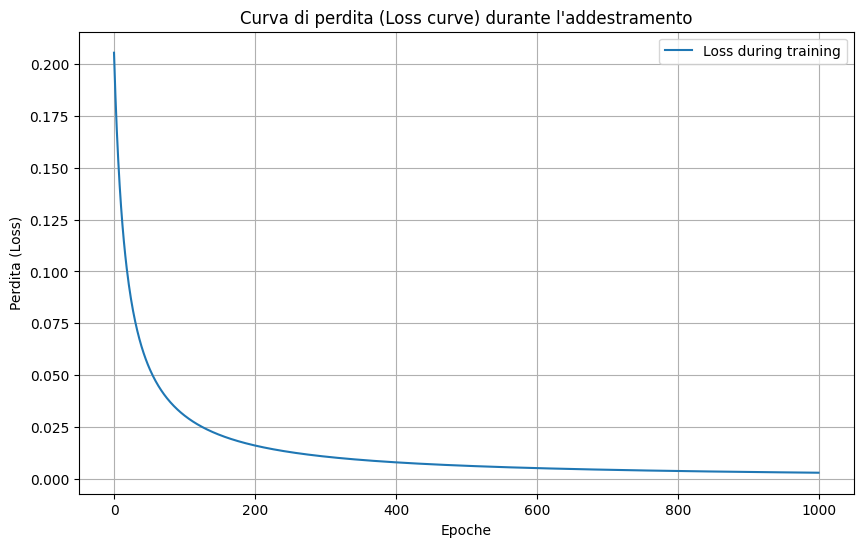

In [3]:
#curva della perdita
plt.figure(figsize=(10, 6))
plt.plot(losses, label="Loss during training")
plt.title("Curva di perdita (Loss curve) durante l'addestramento")
plt.xlabel("Epoche")
plt.ylabel("Perdita (Loss)")
plt.legend()
plt.grid(True)
plt.show()

In [4]:
y_true = np.array([1, 0])  # I veri target
y_pred = nn.predict(X)  # Le previsioni
print(f"Predizioni: {y_pred}")
print(f"Vero target: {y_true}")


Predizioni: [1 0]
Vero target: [1 0]


Ho implementato una rete neurale di base con un singolo strato nascosto e una funzione di attivazione Sigmoid (o ReLU). Viene utilizzata la backpropagation per addestrare il modello e minimizzare la perdita. 

1)**La classe Perceptron** rappresenta un singolo neurone. Un perceptron ha i seguenti componenti:

- Pesi (weights): Un array di valori casuali che rappresentano l'importanza di ciascun input.
- Bias (bias): Un valore che viene aggiunto al risultato della somma pesata degli input, per permettere al neurone di adattarsi meglio.
- Funzione di attivazione (activation_function): La funzione che determina la risposta del neurone dato l'input.

Il perceptron calcola il suo output come la somma pesata degli input più il bias

2) **Classe NeuralNetwork** rappresenta la rete neurale vera e propria. Essa è composta da due strati principali:

- Strato Nascosto (hidden_layer): Ogni neurone in questo strato è un perceptron che riceve in input i dati di addestramento.
- Strato di Output (output_layer): Ogni neurone in questo strato è un perceptron che riceve in input i risultati dello strato nascosto.

**Le funzioni**
- forward(X): Esegue la propagazione in avanti. Calcola l'output della rete a partire dagli input. Viene calcolato il risultato per ciascun neurone in ogni strato della rete, uno alla volta.
- compute_loss(y_true, y_pred): Calcola la perdita (loss) tra i valori reali (y_true) e le previsioni della rete (y_pred)
- backward(X, y): Calcola i gradienti per la backpropagation. Calcola gli errori e i gradienti a partire dall'output fino ai pesi nello strato di input.
- update_parameters(grad_W1, grad_b1, grad_W2, grad_b2, learning_rate): Aggiorna i pesi e i bias utilizzando i gradienti calcolati durante la backpropagation e un tasso di apprendimento (learning_rate).
- train(X, y, learning_rate, epochs) allena la rete neurale utilizzando i dati di addestramento (X per gli input e y per i target). Per ogni epoca si ha: Propagazione in avanti; Calcolo della perdita; calcolo i gradienti; Aggiorno i parametri
- predict(X, threshold) restituisce le previsioni binarie della rete, dove i valori sopra una soglia (di default 0.5) sono classificati come 1 e i valori al di sotto della soglia come 0.

